# Time series of reanalysis data from 20CR project
- calculate anomalies of rainfall for monthly data from the 20CR project 
- do this for four spatial regions 
- then plot results with percentile range 

## the notebook successfully loads the data and calculates anomalies, and does some plots, but the LANDMASK is not working properly yet!! 

In [1]:
import xarray as xr, matplotlib.pyplot as plt
from importlib import reload # need to use this if I edit a function file
import os
import numpy as np
import pandas as pd
import cartopy.crs as ccrs # to add in continents and change map projections 
from matplotlib.colors import LinearSegmentedColormap # to change colour bar????
import dask.diagnostics # dask allows you to check how long something is taking to load
import climtas # needed to count event statistics with a specified duration

In [2]:
# import custom functions
import sys 
sys.path.append('/home/563/kb6999/Functions') # use this if the function file is in a different directory to the notebook

import frequently_used_functions as func
import plotting_functions as fplot
import model_functions as funcM
import reanalysis_functions as funcR

In [149]:
!ls /g/data/ua8/C20C/v3/

about_land_masks.nc  member_daily
land.nc		     member_monthly
LAND.nc		     README_20C_Reanalysis_version_3_everymember.txt
land.sflx.nc	     spread_daily
mean_3hr	     subdaily
mean_daily	     tmp
mean_monthly	     untar.sh


In [29]:
# Create a list with all the strings identifying your members
# use a combination of range and zfill to get the leading zeros.
member_list = [str(x).zfill(2) for x in range(1,81)]

In [126]:
member_list = member_list[slice(0,2)]
member_list

['01', '02']

In [127]:
# load pr data
member_ds_p = {}
for i in member_list:
    path = f'/g/data/ua8/C20C/v3/member_monthly/PRATE/*/*_mem0{i}.nc'
    member_ds_p[i] = xr.open_mfdataset(path), compat='override', data_vars='minimal', coords='minimal')
                                #, combine='nested', join='override') # time variables differ so join eliminates all years except 1850
                                # issues with combine, takes too long to compile without join=override 
    member_ds_p[i] = member_ds_p[i].chunk(chunks={'time':-1})

In [128]:
# concatenate the data into an xarray with the new member dimension
ds_prate = xr.concat(member_ds_p.values(), dim='member')
ds_prate.coords['member'] = member_list

In [129]:
ds_prate.nbytes/(1024*1024)

1992.0818634033203

In [130]:
# combine precipitation and temperature into one dataset
with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    reanal = xr.Dataset({'pr': ds_prate.PRATE})
# change the pr units
reanal['pr'] = reanal.pr*86400
reanal

<xarray.Dataset>
Dimensions:  (lat: 256, lon: 512, member: 2, time: 1992)
Coordinates:
  * lon      (lon) float64 0.0 0.7031 1.406 2.109 ... 357.2 357.9 358.6 359.3
  * lat      (lat) float64 89.46 88.77 88.07 87.37 ... -88.07 -88.77 -89.46
  * time     (time) datetime64[ns] 1850-01-16T10:30:00 ... 2015-12-16T10:30:00
  * member   (member) <U2 '01' '02'
Data variables:
    pr       (member, time, lat, lon) float64 dask.array<chunksize=(1, 1992, 256, 512), meta=np.ndarray>

## Area weighting and land frac

In [150]:
# import landmask dataset 
landfrac_ds = xr.open_dataset('/g/data/ua8/C20C/v3/LAND.nc')
landmask = landfrac_ds.mean(dim='time')

In [132]:
# area weighting 
reanal_w = reanal*np.cos(reanal.lat*(np.pi/180))

In [133]:
data1 = reanal_w.mean(dim=['lat','lon','member'])

When I had tmp and pr combined in a dataset and then tried to just plot pr, it didn't work, the kernel died.  I'll try the same thing, but without tmp in the datset and see if it works!!

[########################################] | 100% Completed | 45.8s


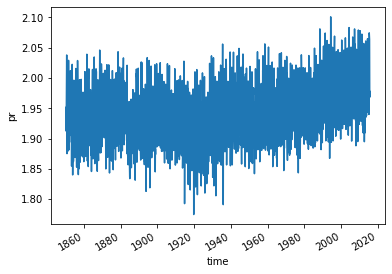

In [134]:
fig, axes = plt.subplots(1, 1) # make a figure
with dask.diagnostics.ProgressBar():
    data1.pr.plot(ax=axes)

## Group the data by month

In [135]:
# group the data by month (take the monthly mean)
reanal_mon = reanal_w.resample(time='M').mean(dim='time')

In [136]:
reanal_mon

,Array,Chunk
Bytes,4.18 GB,1.05 MB
Shape,"(1992, 2, 256, 512)","(1, 1, 256, 512)"
Count,20927 Tasks,3984 Chunks
Type,float64,numpy.ndarray


In [137]:
# use functions to calculate the monthly anomalies for the globe
monthly_anom_glob = func.monthly_anomaly(reanal_mon, '1850-01', '1881-01')

In [138]:
data = monthly_anom_glob.sel(time=slice('1850-01','1900-01')).mean(dim=['lat','lon','member'])

[########################################] | 100% Completed | 34.5s


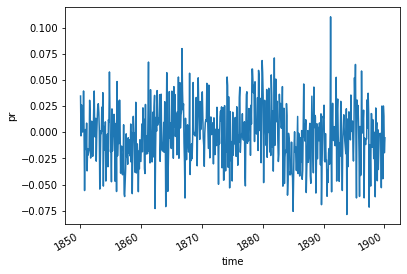

In [139]:
fig, axes = plt.subplots(1,1) # make a figure
with dask.diagnostics.ProgressBar():
    data.pr.plot(ax=axes)

In [140]:
# Select out SH and NH anomalies 
monthly_anom_SH = monthly_anom_glob.sel(lat=slice(-90,0)) 
monthly_anom_NH = monthly_anom_glob.sel(lat=slice(0,90)) 

# below cell converts type of array
.astype('float32',casting='same_kind')

changed landmask to use other landmask.LAND file (instead of .land) and it fixed problems

In [154]:
# select out the Australian and E Australian anomalies 
monthly_anom_Aus = monthly_anom_glob.sel(lat=slice(-50,-10), lon=slice(110,160)).where(landmask.LAND==1.0, drop=True)
monthly_anom_EA = monthly_anom_glob.sel(lat=slice(-50,-10), lon=slice(140,155)).where(landmask.LAND==1.0, drop=True)

In [168]:
landmask

<xarray.Dataset>
Dimensions:  (lat: 256, lon: 512)
Coordinates:
  * lon      (lon) float64 0.0 0.7031 1.406 2.109 ... 357.2 357.9 358.6 359.3
  * lat      (lat) float64 89.46 88.77 88.07 87.37 ... -88.07 -88.77 -89.46
Data variables:
    LAND     (lat, lon) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0 1.0 1.0

## Multi-member mean

In [155]:
# take the lat lon mean for mmm datsets for each region
llm_Glob = monthly_anom_glob.mean(dim=['lat','lon'])
llm_SH = monthly_anom_SH.mean(dim=['lat','lon'])
llm_NH = monthly_anom_NH.mean(dim=['lat','lon'])
llm_Aus = monthly_anom_Aus.mean(dim=['lat','lon'])
llm_EA = monthly_anom_EA.mean(dim=['lat','lon'])

In [156]:
# Take the multi-member mean for each region
mmm_mon_Glob = monthly_anom_glob.mean(dim='member').mean(dim=['lat','lon'])
mmm_mon_SH = monthly_anom_SH.mean(dim='member').mean(dim=['lat','lon'])
mmm_mon_NH = monthly_anom_NH.mean(dim='member').mean(dim=['lat','lon'])
mmm_mon_Aus = monthly_anom_Aus.mean(dim='member').mean(dim=['lat','lon'])
mmm_mon_EA = monthly_anom_EA.mean(dim='member').mean(dim=['lat','lon'])

## Percentiles

In [157]:
# calculate the percentiles and then take the mean along the model dimension for monthly anomalies
p10_mon_Glob = llm_Glob.chunk({'member': -1}).quantile(0.1, dim=['member'])
p10_mon_SH = llm_SH.chunk({'member': -1}).quantile(0.1, dim=['member'])
p10_mon_NH = llm_NH.chunk({'member': -1}).quantile(0.1, dim=['member'])
p10_mon_Aus = llm_Aus.chunk({'member': -1}).quantile(0.1, dim=['member'])
p10_mon_EA = llm_EA.chunk({'member': -1}).quantile(0.1, dim=['member'])

In [171]:
p10_mon_Glob.pr

<xarray.DataArray 'pr' (time: 1992)>
dask.array<getitem, shape=(1992,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) datetime64[ns] 1850-01-31 1850-02-28 ... 2015-12-31
    month     (time) int64 dask.array<chunksize=(1992,), meta=np.ndarray>
    quantile  float64 0.1

In [158]:
# calculate the percentiles and then take the mean along the model dimension for monthly anomalies
p90_mon_Glob = llm_Glob.chunk({'member': -1}).quantile(0.9, dim=['member'])
p90_mon_SH = llm_SH.chunk({'member': -1}).quantile(0.9, dim=['member'])
p90_mon_NH = llm_NH.chunk({'member': -1}).quantile(0.9, dim=['member'])
p90_mon_Aus = llm_Aus.chunk({'member': -1}).quantile(0.9, dim=['member'])
p90_mon_EA = llm_EA.chunk({'member': -1}).quantile(0.9, dim=['member'])

## Figures

In [159]:
# define degree sign
deg = u'\N{DEGREE SIGN}'

[########################################] | 100% Completed |  1min  8.2s
[##################                      ] | 45% Completed | 49.2s

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.01/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed |  1min  7.2s


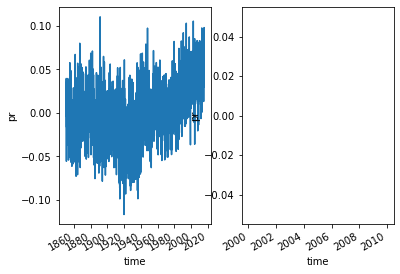

In [166]:
# Monthly rainfall anomalies
fig, axes = plt.subplots(2, 1) # make a figure
with dask.diagnostics.ProgressBar():
    mmm_mon_Glob.pr.plot(ax=axes[0])
    mmm_mon_Aus.pr.plot(ax=axes[1])


Kernel died for tmp above, but now i'm trying for pr without tmp in the original dataset

[########################################] | 100% Completed |  1min 11.7s
[########################################] | 100% Completed |  1min 12.1s
[########################################] | 100% Completed |  1min 20.6s
[#                                       ] | 3% Completed | 20.7s

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.01/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[#################                       ] | 44% Completed | 47.6s

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.01/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


[########################################] | 100% Completed |  1min  3.9s
[#                                       ] | 3% Completed | 22.7s

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.01/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[#################                       ] | 44% Completed | 47.8s

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.01/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


[########################################] | 100% Completed |  1min  5.3s
[#################                       ] | 44% Completed | 48.6s

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.01/lib/python3.8/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


[########################################] | 100% Completed |  1min  5.1s


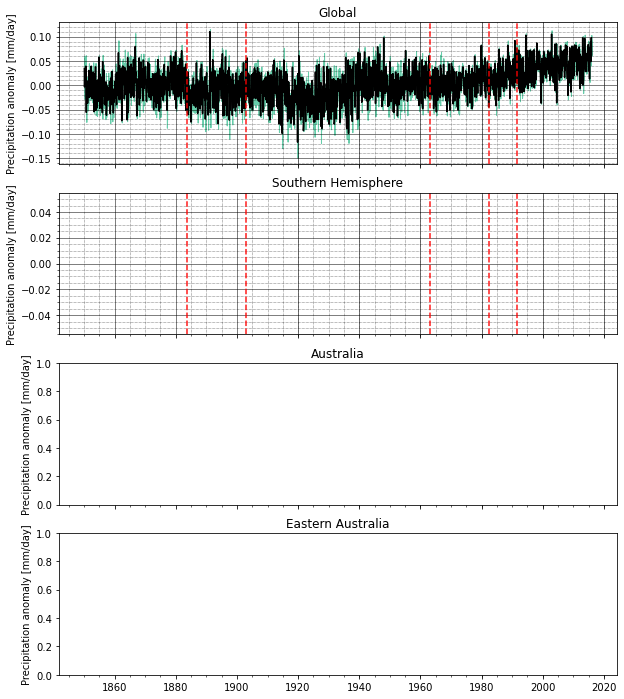

In [177]:
# same plot but stacked rather than 2x2
fig, axes = plt.subplots(4, 1, sharex=True, figsize=(10,12)) # make a figure

with dask.diagnostics.ProgressBar():
    fplot.timeseries_graph(mmm_mon_Glob.pr, p10_mon_Glob.pr, p90_mon_Glob.pr, ax = axes[0], color='mediumaquamarine')
    fplot.timeseries_graph(mmm_mon_SH.pr, p10_mon_SH.pr, p90_mon_SH.pr, ax = axes[1], color='mediumaquamarine')
#     fplot.timeseries_graph(mmm_mon_Aus.pr, p10_mon_Aus.pr, p90_mon_Aus.pr, ax = axes[2], color='mediumaquamarine')
#     fplot.timeseries_graph(mmm_mon_EA.pr, p10_mon_EA.pr, p90_mon_EA.pr, ax = axes[3], color='mediumaquamarine')

# set axis labels and subplot titles
axes[0].set(ylabel= 'Precipitation anomaly [mm/day]', title = 'Global') 
axes[1].set(ylabel= 'Precipitation anomaly [mm/day]', title = 'Southern Hemisphere')
axes[2].set(ylabel= 'Precipitation anomaly [mm/day]', title = 'Australia')
axes[3].set(ylabel= 'Precipitation anomaly [mm/day]', title = 'Eastern Australia')

#fig.suptitle('Time series of precipitation anomalies', size=16)

#fig.tight_layout() # stops things from overlapping and makes the figure more compact

plt.savefig('R_timeseries_mon_pr_stacked.png', dpi=300, bbox_inches='tight')

# Zoom in on Krakatoa time period

In [180]:
# eruption date
e_date = pd.to_datetime(['1883-08','1902-10', '1963-03', '1982-04', '1991-06'])

In [181]:
# save arrays of times relative to each eruption
e_pre5yrs = e_date - 60 * pd.offsets.MonthBegin()
e_pre3mon = e_date - 3 * pd.offsets.MonthBegin()
e_post5yrs = e_date + 61 * pd.offsets.MonthBegin()
e_post10yrs = e_date + 121 * pd.offsets.MonthBegin()

In [182]:
# Zoom in on Krakatoa time period
K_mmm_Glob = mmm_mon_Glob.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_mmm_SH = mmm_mon_SH.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_mmm_Aus = mmm_mon_Aus.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_mmm_EA = mmm_mon_EA.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))

K_p10_Glob = p10_mon_Glob.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_p10_SH = p10_mon_SH.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_p10_Aus = p10_mon_Aus.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_p10_EA = p10_mon_EA.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))

K_p90_Glob = p90_mon_Glob.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_p90_SH = p90_mon_SH.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_p90_Aus = p90_mon_Aus.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))
K_p90_EA = p90_mon_EA.sel(time = slice(e_pre5yrs[0], e_post5yrs[0]))

In [ ]:
# Monthly precipitation anomalies for Krakatoa
fig, axes = plt.subplots(2, 2, sharex=True, figsize=(15,10)) # make a figure

# make subplots for each region
fplot.timeseries_graph(K_mmm_Glob.pr, K_p10_Glob.pr, K_p90_Glob.pr, ax = axes[0,0], color='mediumaquamarine')
fplot.timeseries_graph(K_mmm_SH.pr, K_p10_SH.pr, K_p90_SH.pr, ax = axes[0,1], color='mediumaquamarine')
fplot.timeseries_graph(K_mmm_Aus.pr, K_p10_Aus.pr, K_p90_Aus.pr, ax = axes[1,0], color='mediumaquamarine')
fplot.timeseries_graph(K_mmm_EA.pr, K_p10_EA.pr, K_p90_EA.pr, ax = axes[1,1], color='mediumaquamarine')

# set axis labels and subplot titles
axes[0,0].set(ylabel='Precipitation anomaly [mm/day]', title = 'Global') 
axes[0,1].set(title = 'Southern Hemisphere')
axes[1,0].set(ylabel='Precipitation anomaly [mm/day]', title = 'Australia')
axes[1,1].set(title = 'Eastern Australia')

# set the axis ticks to be monthly 
axes[0,0].set_xticks(years)
axes[0,0].set_xticklabels(years.year) # .year displays only the year (not month time etc)

plt.savefig('R_K_timeseries_mon_pr.png', dpi=300, bbox_inches='tight')

In [ ]:
# same plot but stacked rather than 2x2
fig, axes = plt.subplots(4, 1, sharex=True, figsize=(10,12)) # make a figure

with dask.diagnostics.ProgressBar():
    fplot.timeseries_graph(mmm_mon_Glob.pr, p10_mon_Glob.pr, p90_mon_Glob.pr, ax = axes[0], color='mediumaquamarine')
    fplot.timeseries_graph(mmm_mon_SH.pr, p10_mon_SH.pr, p90_mon_SH.pr, ax = axes[1], color='mediumaquamarine')
    fplot.timeseries_graph(mmm_mon_Aus.pr, p10_mon_Aus.pr, p90_mon_Aus.pr, ax = axes[2], color='mediumaquamarine')
    fplot.timeseries_graph(mmm_mon_EA.pr, p10_mon_EA.pr, p90_mon_EA.pr, ax = axes[3], color='mediumaquamarine')

# set axis labels and subplot titles
axes[0].set(ylabel= 'Precipitation anomaly [mm/day]', title = 'Global') 
axes[1].set(ylabel= 'Precipitation anomaly [mm/day]', title = 'Southern Hemisphere')
axes[2].set(ylabel= 'Precipitation anomaly [mm/day]', title = 'Australia')
axes[3].set(ylabel= 'Precipitation anomaly [mm/day]', title = 'Eastern Australia')

#fig.suptitle('Time series of precipitation anomalies', size=16)

#fig.tight_layout() # stops things from overlapping and makes the figure more compact

plt.savefig('R_timeseries_mon_pr_stacked.png', dpi=300, bbox_inches='tight')